#Big Data Computing Project

This notebook contains the Michele Spina's (1711821) project for the cource of Big Data Computing of the a.y. 2022/23.

In [1]:
#install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 19.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d8c80ad86335b20a41a6ce594dbc37baa7cca9944acb64f54a90853a51fd7b26
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
# Import libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
sc._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.id', 'local-1656140919905'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '4aed89fdd1a4'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxRe

## The Dataset

For this project I choose a dataset from Kraggle about airline passeger satistation. 
The goal of this project is to predict if the passegers are satisfied or not, so I have to apply a binary prediction.

[Source](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv)



---



Now let's import the dataset and observe what it contains.

In [6]:
# Import the dataset

#from google.colab import drive
import pandas as pd

GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BigDataComputing"
TRAIN_DATA_PATH = GDRIVE_DATA_DIR + '/train.gsheet'
TEST_DATA_PATH = GDRIVE_DATA_DIR + '/test.gsheet'

TRAIN_DATA_PATH = '/content/data/train.csv'
TEST_DATA_PATH  = '/content/data/test.csv'

#drive.mount(GDRIVE_DIR, force_remount=True)


In [7]:
train_df = spark.read.load(TRAIN_DATA_PATH, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

test_df = spark.read.load(TEST_DATA_PATH, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

In [8]:
train_df.head()

Row(_c0=0, id=70172, Gender='Male', Customer Type='Loyal Customer', Age=13, Type of Travel='Personal Travel', Class='Eco Plus', Flight Distance=460, Inflight wifi service=3, Departure/Arrival time convenient=4, Ease of Online booking=3, Gate location=1, Food and drink=5, Online boarding=3, Seat comfort=5, Inflight entertainment=5, On-board service=4, Leg room service=3, Baggage handling=4, Checkin service=4, Inflight service=5, Cleanliness=5, Departure Delay in Minutes=25, Arrival Delay in Minutes=18.0, satisfaction='neutral or dissatisfied')

In [9]:
test_df.head()

Row(_c0=0, id=19556, Gender='Female', Customer Type='Loyal Customer', Age=52, Type of Travel='Business travel', Class='Eco', Flight Distance=160, Inflight wifi service=5, Departure/Arrival time convenient=4, Ease of Online booking=3, Gate location=4, Food and drink=3, Online boarding=4, Seat comfort=3, Inflight entertainment=5, On-board service=5, Leg room service=5, Baggage handling=5, Checkin service=2, Inflight service=5, Cleanliness=5, Departure Delay in Minutes=50, Arrival Delay in Minutes=44.0, satisfaction='satisfied')

This datase have been already cleaned, but observe the consistents of the data if fundamental practice before use a Dataset.

In [10]:
#I want to concatene test and union to observe the dataset
df = train_df.union(test_df)
df.show(n=5, truncate=False)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id    |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+---------

In [11]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanline

In [12]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 129880 rows by 25 columns


In [13]:
print(df.dtypes)

[('_c0', 'int'), ('id', 'int'), ('Gender', 'string'), ('Customer Type', 'string'), ('Age', 'int'), ('Type of Travel', 'string'), ('Class', 'string'), ('Flight Distance', 'int'), ('Inflight wifi service', 'int'), ('Departure/Arrival time convenient', 'int'), ('Ease of Online booking', 'int'), ('Gate location', 'int'), ('Food and drink', 'int'), ('Online boarding', 'int'), ('Seat comfort', 'int'), ('Inflight entertainment', 'int'), ('On-board service', 'int'), ('Leg room service', 'int'), ('Baggage handling', 'int'), ('Checkin service', 'int'), ('Inflight service', 'int'), ('Cleanliness', 'int'), ('Departure Delay in Minutes', 'int'), ('Arrival Delay in Minutes', 'double'), ('satisfaction', 'string')]


In [14]:
df.describe("age").show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            129880|
|   mean| 39.42795657530028|
| stddev|15.119359950371678|
|    min|                 7|
|    max|                85|
+-------+------------------+



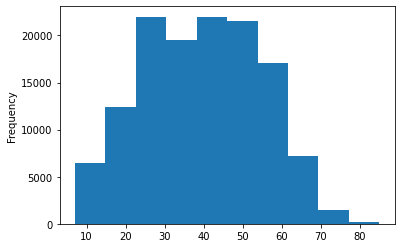

In [15]:
pan_df = df.toPandas()
pan_df.Age.plot.hist()

In [16]:
pan_df.isnull().sum()

_c0                                    0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

In [17]:
pan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   _c0                                129880 non-null  int32  
 1   id                                 129880 non-null  int32  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int32  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int32  
 8   Inflight wifi service              129880 non-null  int32  
 9   Departure/Arrival time convenient  129880 non-null  int32  
 10  Ease of Online booking             129880 non-null  int32  
 11  Gate location                      1298

`Arrival Delay in Minutes` column contains 379 null-values. There are many differt ways to manage this inconcistent


*   Delete the inconsistent column
*   Delete the inconsistent rows
*   Substitute inconsistent using mean value
*   Substitute inconsistent using mean value adding a boolean attribute to individuate virtual values from original
*   Use linear regression to substitute inconsistent values

We'll apply the 4th options.

In [18]:
pan_df.describe()

,_c0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,44158.700000,64940.500000,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,31207.377062,37493.270818,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16234.750000,32470.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,38963.500000,64940.500000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,71433.250000,97410.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [19]:
'''
df_extraC = pan_df.copy()
df_extraC['Arrival Delay in Minutes is Missing'] = df_extraC['Arrival Delay in Minutes'] == None
from sklearn.impute import SimpleImputer
#my_imputer = SimpleImputer(strategy = 'median')
#data_new = my_imputer.fit_transform(df_extraC)

cleanup_inconsisten = {"Cholesterol":     {None: 244.635389},
                'CholesterolIsMissing': {False: 0, True: 1},
               }
df_extraC = df_extraC.replace(cleanup_inconsisten)
#df_extraC = df_extraC.replace(cleanup_nums)

df_extraC.describe()
'''

'\ndf_extraC = pan_df.copy()\ndf_extraC[\'Arrival Delay in Minutes is Missing\'] = df_extraC[\'Arrival Delay in Minutes\'] == None\nfrom sklearn.impute import SimpleImputer\n#my_imputer = SimpleImputer(strategy = \'median\')\n#data_new = my_imputer.fit_transform(df_extraC)\n\ncleanup_inconsisten = {"Cholesterol":     {None: 244.635389},\n                \'CholesterolIsMissing\': {False: 0, True: 1},\n               }\ndf_extraC = df_extraC.replace(cleanup_inconsisten)\n#df_extraC = df_extraC.replace(cleanup_nums)\n\ndf_extraC.describe()\n'

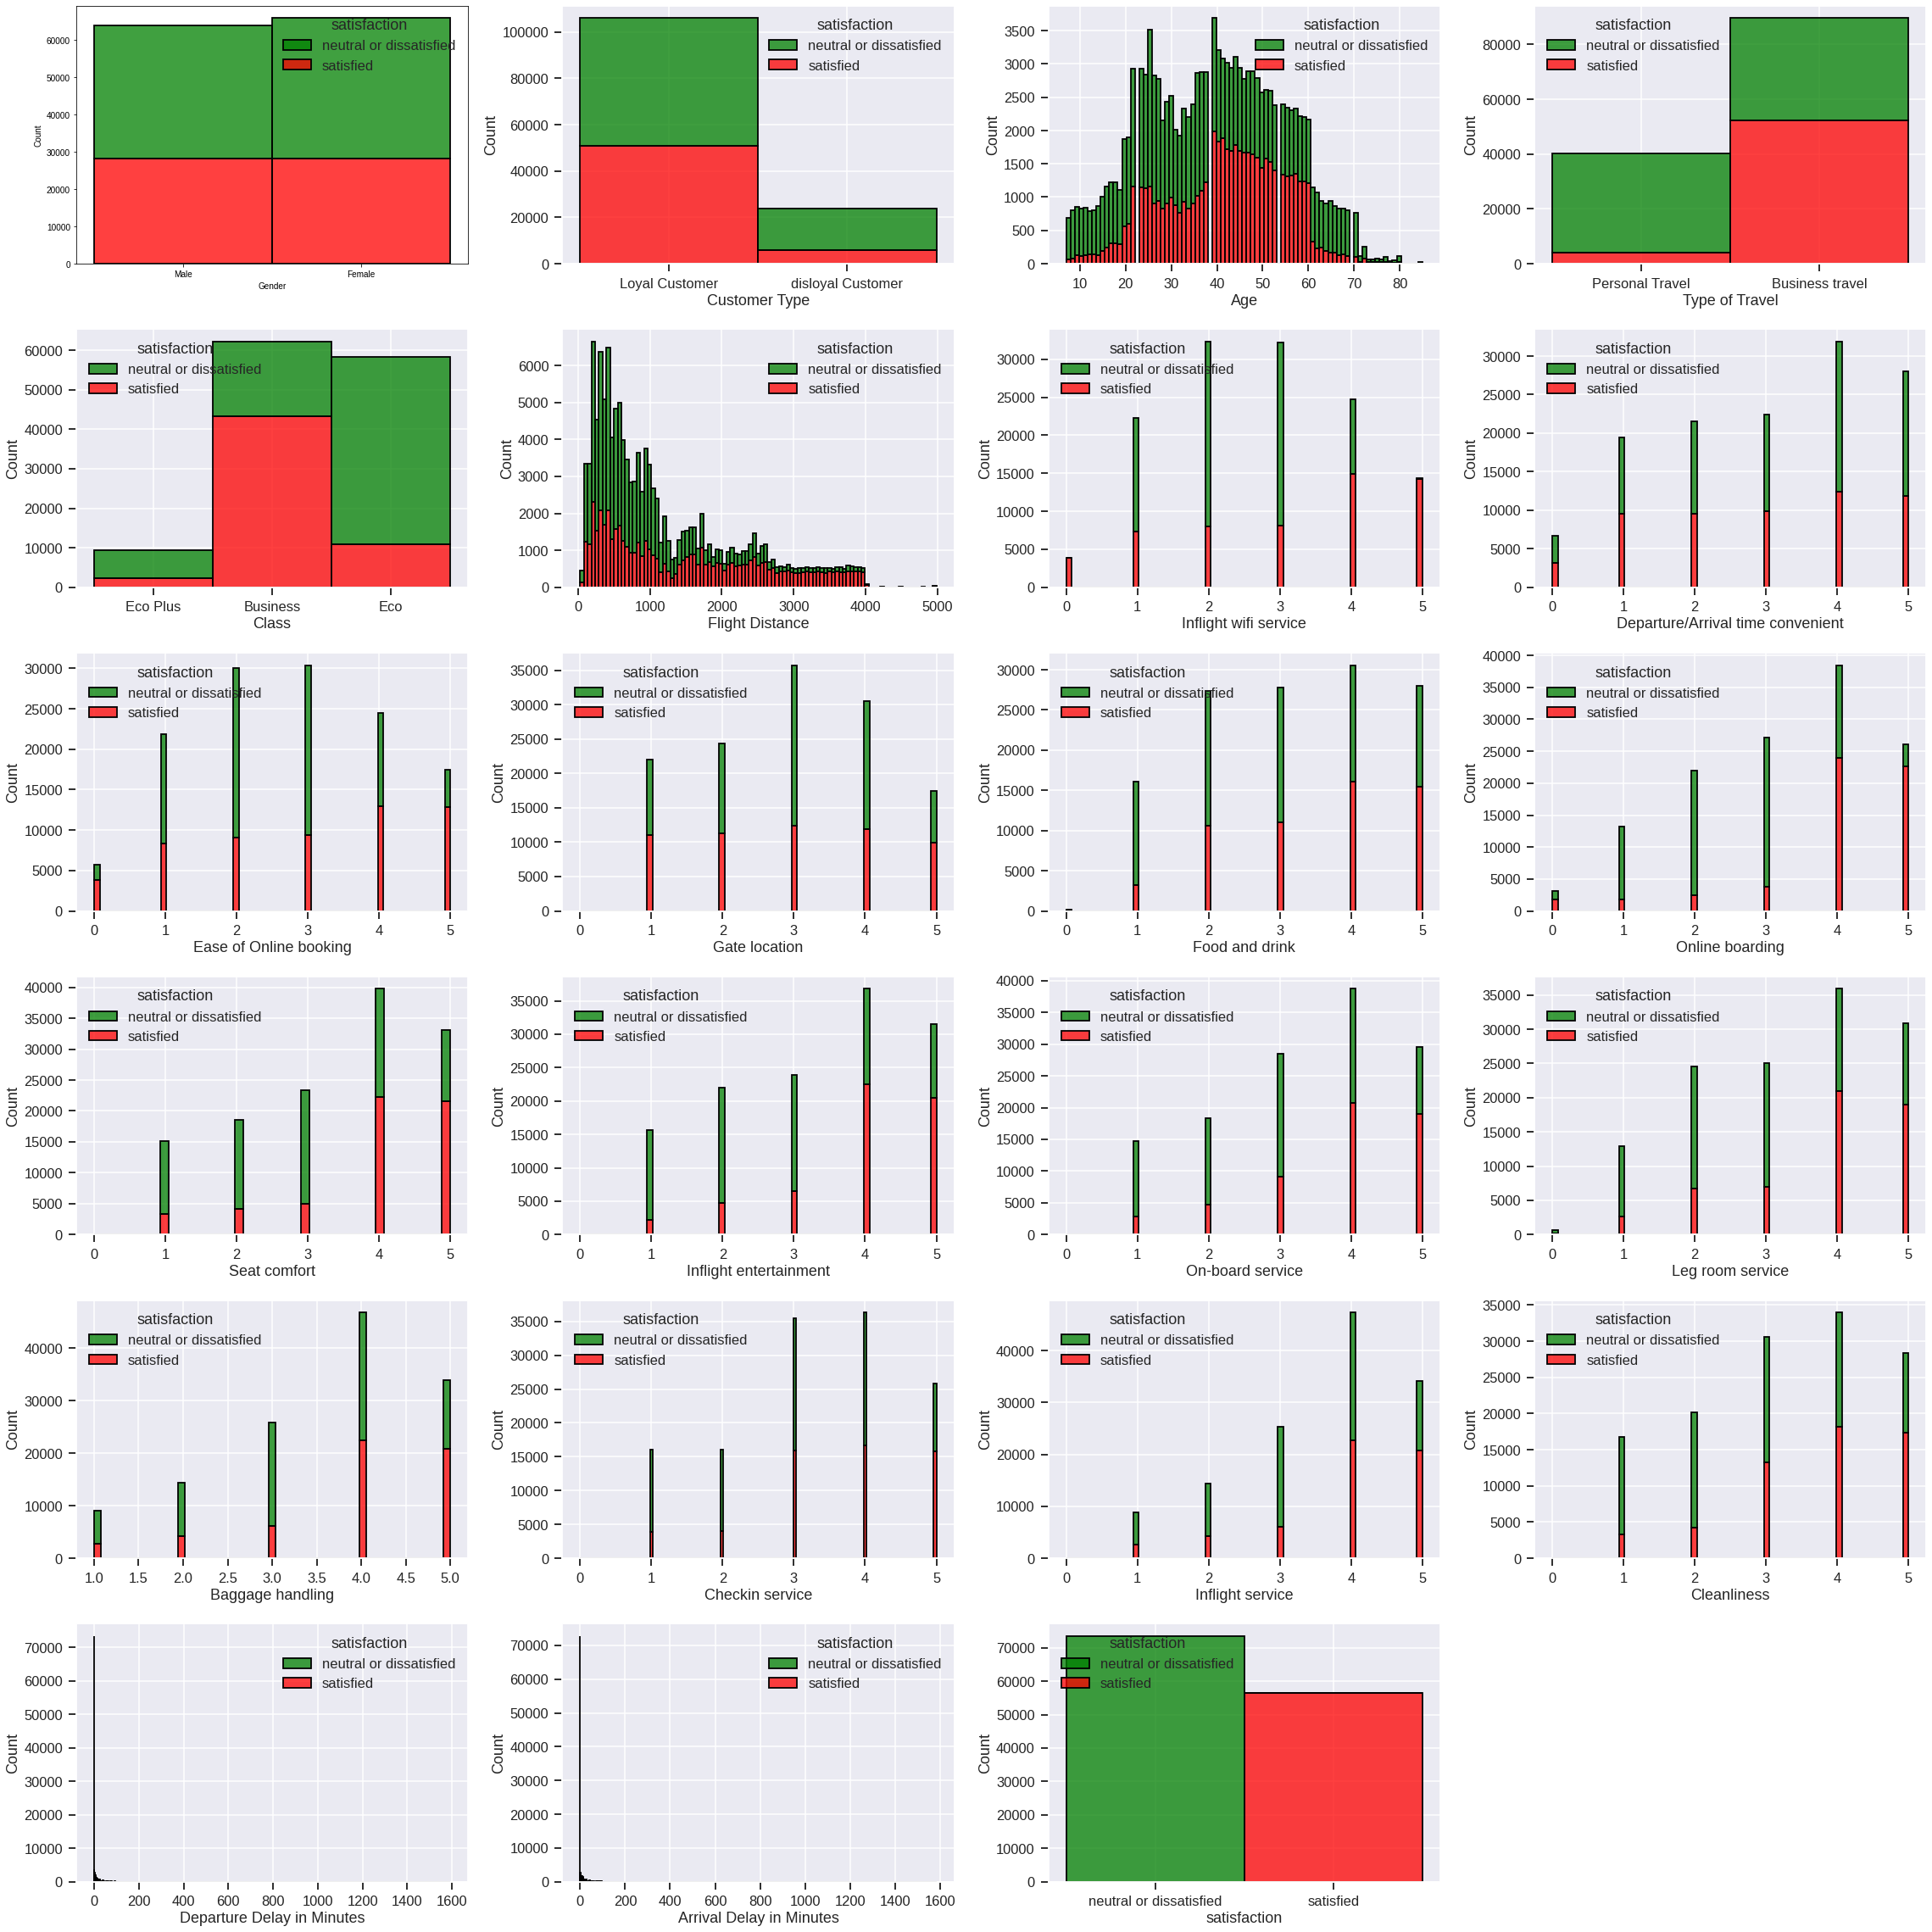

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

oe=['g','r']
fig = plt.figure(figsize=(32,32))

rows = 6
cols = 4
pos = 1

for col_name in pan_df.columns[2:]:
  plt.subplot(rows,cols,pos)
  plt.style.use('seaborn')
  plt.tight_layout()
  sns.set_context('talk')
  sns.histplot(data=pan_df, x=col_name, hue="satisfaction", linewidth = 1.8, multiple="stack",palette=oe)
  pos += 1

In [21]:
def correlation_matrix(df: DataFrame):
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(df.corr(), cmap="YlGnBu")

## Correlation Matrix

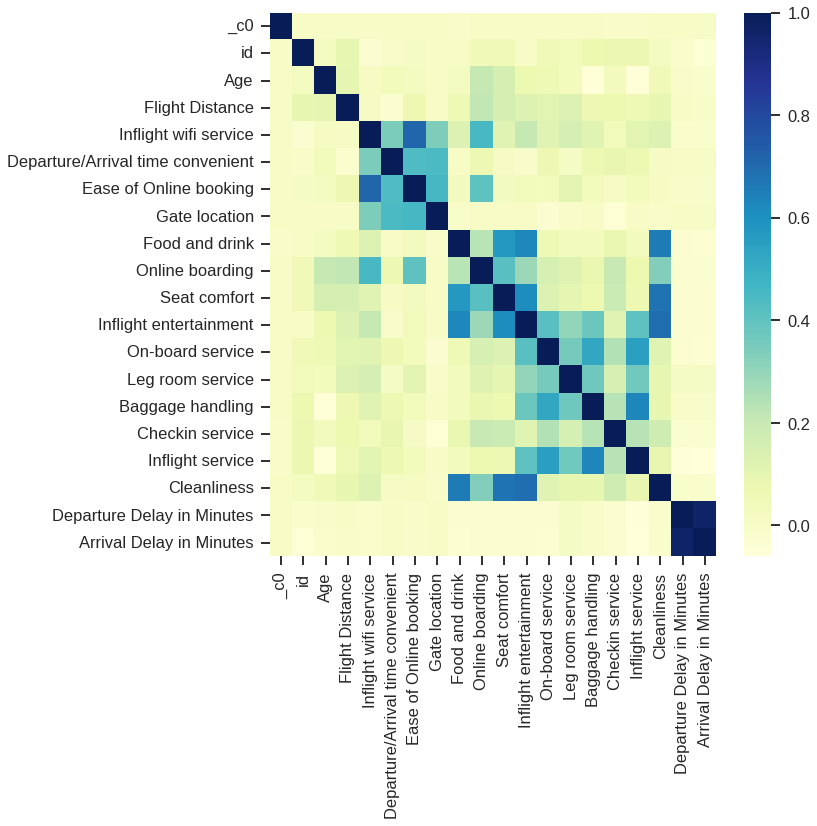

In [22]:
correlation_matrix(pan_df)

In [23]:
def show_graphics(df: DataFrame):
  graphics = 5
  fig, ax = plt.subplots(1, graphics, figsize=(25, 5))
  graphics_data = [('Departure Delay in Minutes', 'Arrival Delay in Minutes'), ('Cleanliness', 'Inflight entertainment'), ('Ease of Online booking', 'Inflight wifi service'), ('Cleanliness', 'Inflight entertainment'), ('Cleanliness', 'Inflight entertainment')]
  for i, j in enumerate(ax):
    x = graphics_data[i][0]
    y = graphics_data[i][1]
    ax[i].scatter(df[x], y=df[y], c=df[x])
    ax[i].set_xlabel(x)
    ax[i].set_ylabel(y)
  plt.show()
  

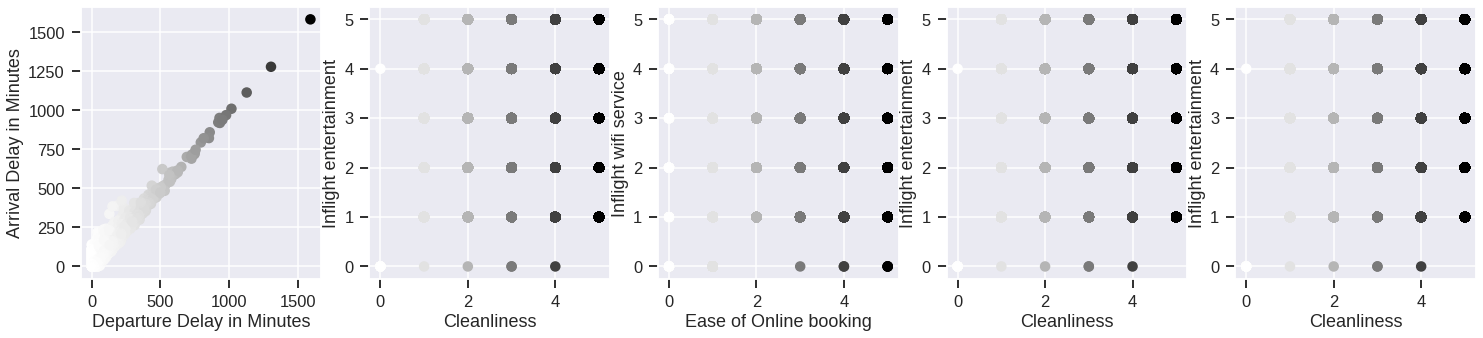

In [24]:
show_graphics(pan_df)

# Drop columns

In [25]:
COLUMNS_TO_DROP = ['_c0', 'id','Arrival Delay in Minutes']

In [26]:
COLUMNS_TO_DROP_AGAIN = ['satisfaction']

In [27]:
df = df.drop(*COLUMNS_TO_DROP)
df.na.drop()
#df = df.withColumn("Satisfied", col('satisfaction') == 'satisfied')
#df = df.drop('satisfaction')
df.schema 

StructType([StructField('Gender', StringType(), True), StructField('Customer Type', StringType(), True), StructField('Age', IntegerType(), True), StructField('Type of Travel', StringType(), True), StructField('Class', StringType(), True), StructField('Flight Distance', IntegerType(), True), StructField('Inflight wifi service', IntegerType(), True), StructField('Departure/Arrival time convenient', IntegerType(), True), StructField('Ease of Online booking', IntegerType(), True), StructField('Gate location', IntegerType(), True), StructField('Food and drink', IntegerType(), True), StructField('Online boarding', IntegerType(), True), StructField('Seat comfort', IntegerType(), True), StructField('Inflight entertainment', IntegerType(), True), StructField('On-board service', IntegerType(), True), StructField('Leg room service', IntegerType(), True), StructField('Baggage handling', IntegerType(), True), StructField('Checkin service', IntegerType(), True), StructField('Inflight service', Integ

# Machine Learning Models

In [28]:
df.show(n=5, truncate=False)

+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+-----------------------+
|Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|satisfaction           |
+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+-----------

#### Define the pipeline
Here I defined a general pipeline for all the models.

In particular I'll use this Pipeline:
<ul>
  <li><code>StringIndexer</code>: it encodes string column of labels to a column of label indices;</li>
  <li><code>OneHotEncoder</code>: it maps a categorical feature (represented as a lable index) to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values;</li>
  <li><code>VectorAssembler</code>: it is a transformer that combines a given list of columns into a single vector column;</li>
  <li><code>StandardScaler</code>: it transsforms a dataset of <code>Vector</code> rows, normalizing each feature to have unit standard deviation and/or zero mean;</li>
  <li><code>MODEL</code>: the model to train that could be the <code>Logistic Regression, Decision Tree or Random Forest</code>.</li>
</ul>

In [29]:
from typing import List, Callable
def general_pipeline(df: DataFrame, numerical_features: List[str], categorical_features: List[str], target_variable: str, with_std: bool = True, with_mean: bool = True, scaler: bool = False):
  from pyspark.ml import Pipeline
  from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
  
  indexers = [StringIndexer(inputCol=c, outputCol="{}_indexed".format(c), handleInvalid="skip") for c in categorical_features]
  
  encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{}_encoded".format(indexer.getOutputCol()) for indexer in indexers], handleInvalid="keep")
  
  label_indexer = StringIndexer(inputCol=target_variable, outputCol="label", handleInvalid="skip")
  
  assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
  
  if scaler:
    scaler_vect = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    stages = indexers + [encoder] + [label_indexer] + [assembler] + [scaler_vect]
  else:
    stages = indexers + [encoder] + [label_indexer] + [assembler]
    
  pipeline = Pipeline(stages=stages)
  transformer = pipeline.fit(df)
  df_transformed = transformer.transform(df)
  return transformer, df_transformed

In [30]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

This is the experiments' list. Just uncomment one of them and run the training. Each experiment is a tuple (<code>oversampled_dataset : bool, folder_for_the_model : str, dataset_to_use : [0, 1], model_to_use : pySparkModel, normalize_vectors : bool</code>)

In [31]:
# experiments: dict with tuples as values (oversampled, path, dataset_used, model, standardized), dataset_used = 0, 1 -> all asteroids, near earth asteroids
# just comment experiments to avoid!
experiments = {
  #"logistic_regression_no_std": (False, "log_reg_model_no_std", 0, LogisticRegression, False),
  #"logistic_regression_std": (False, "log_reg_model_std", 0, LogisticRegression, True),
  #"logistic_regression_oversampled_no_std": (True, "log_reg_model_oversampled_no_std", 0, LogisticRegression, False),
  #"logistic_regression_oversampled_std": (True, "log_reg_model_oversampled_std", 0, LogisticRegression, True),
  #"logistic_regression_std_nea": (False, "log_reg_model_std_nea", 1, LogisticRegression, True),
  #"logistic_regression_no_std_nea": (False, "log_reg_model_no_std_nea", 1, LogisticRegression, False),
  #"logistic_regression_oversampled_no_std_nea": (True, "log_reg_model_oversampled_no_std_nea", 1, LogisticRegression, False),
  #"logistic_regression_oversampled_std_nea": (True, "log_reg_model_oversampled_std_nea", 1, LogisticRegression, True),
  
  #"dec_tree_no_std": (False, "dec_tree_no_std", 0, DecisionTreeClassifier, False),
  #"dec_tree_std": (False, "dec_tree_std", 0, DecisionTreeClassifier, True),
  #"decision_tree_oversampled_no_std": (True, "decision_tree_oversampled_no_std", 0, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_std": (True, "decision_tree_oversampled_std", 0, DecisionTreeClassifier, True),
  #"dec_tree_std_nea": (False, "dec_tree_std_nea", 1, DecisionTreeClassifier, True),
  #"dec_tree_no_std_nea": (False, "dec_tree_no_std_nea", 1, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_no_std_nea": (True, "decision_tree_oversampled_no_std_nea", 1, DecisionTreeClassifier, False),
  #"decision_tree_oversampled_std_nea": (True, "decision_tree_oversampled_std_nea", 1, DecisionTreeClassifier, True),
  
  #"random_forest_no_std": (False, "random_forest_no_std", 0, RandomForestClassifier, False),
  #"random_forest_std": (False, "random_forest_std", 0, RandomForestClassifier, True),
  #"random_forest_oversampled_no_std": (True, "random_forest_oversampled_no_std", 0, RandomForestClassifier, False),
  #"random_forest_oversampled_std": (True, "random_forest_oversampled_std", 0, RandomForestClassifier, True),
  #"random_forest_std_nea": (False, "random_forest_std_nea", 1, RandomForestClassifier, True),
  #"random_forest_no_std_nea": (False, "random_forest_no_std_nea", 1, RandomForestClassifier, False),
  #"random_forest_oversampled_no_std_nea": (True, "random_forest_oversampled_no_std_nea", 1, RandomForestClassifier, False),
  #"random_forest_oversampled_std_nea": (True, "random_forest_oversampled_std_nea", 1, RandomForestClassifier, True)
}

CATEGORICAL_FEATURES = ['Gender', 'Customer Type', 'Class', 'Type of Travel'] # they are the CATEGORICAL FEATURES
NUMERICAL_FEATURES = ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes']

<code>plot_recision_recall, plot_coefficients, plot_roc, plot_confusion_matrix, calculate_metrics, metrics_calculation</code> are utility functions.

In [32]:
def plot_precision_recall(model):
  training_summary = model.summary
  precision_recall = training_summary.pr.toPandas()
  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=precision_recall['recall'], y=precision_recall['precision'], marker="s", axes=ax)
  _ = ax.set_xlabel("Recall", labelpad=20)
  _ = ax.set_ylabel("Precision", labelpad=20)
  _ = ax.set_title("Precision vs. Recall")

In [33]:
import numpy as np
def plot_coefficients(model):
  theta = np.sort(model.coefficients)
  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=range(0,len(model.coefficients)), y=theta, marker="o", axes=ax)
  _ = ax.set_xlabel("Theta Index", labelpad=20)
  _ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)

In [34]:
def plot_roc(model):
  roc = model.summary.roc.toPandas()

  fig, ax = plt.subplots(1, 1, figsize=(8,6))
  _ = sns.lineplot(x=roc['FPR'], y=roc['TPR'], marker="s", axes=ax)
  _ = ax.set_xlabel("False Positive Rate", labelpad=20)
  _ = ax.set_ylabel("True Positive Rate", labelpad=20)
  _ = ax.set_title("ROC Curve")
  print('Training Set AUC: {:.3f}'.format(model.summary.areaUnderROC))

In [35]:
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  print(cm)
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [36]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(predictions):
  y_true = predictions.select("label")
  y_true = y_true.toPandas()

  y_pred = predictions.select("prediction")
  y_pred = y_pred.toPandas()

  confusion_matrix_lr = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0])
  plt.figure()
  plot_confusion_matrix(confusion_matrix_lr, classes=[0.0, 1.0], title='Confusion matrix lr')
  plt.show()

In [37]:

def metrics_calculation(y_test, pred):
  precision = precision_score(y_test, pred, average = "macro")
  recall = recall_score(y_test, pred, average = "macro")
  accuracy = accuracy_score(y_test, pred)
  f1score = (2 * (precision * recall))/(precision + recall)
  print('Precision metric: {}'.format(precision))
  print('Recall Metric: {}'.format(recall))
  print('Accuracy Metric: {}'.format(accuracy))
  print('F1-score Metric: {}'.format(f1score))
  

In the cell below there is the code to run the experiments that are present in the experiments dictionary.

In [39]:
print(df.columns)

['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'satisfaction']


In [40]:
transformer, transformed = general_pipeline(df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, 'satisfaction')
train_df, test_df = transformed.randomSplit([0.7, 0.3])

## Binomial Logistic regression
Show the results for binomial logistic regression experiments (loading the previous models)

In [69]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

lrmodel = lr.fit(train_df)

output = lrmodel.transform(test_df)

print(output)


DataFrame[Gender: string, Customer Type: string, Age: int, Type of Travel: string, Class: string, Flight Distance: int, Inflight wifi service: int, Departure/Arrival time convenient: int, Ease of Online booking: int, Gate location: int, Food and drink: int, Online boarding: int, Seat comfort: int, Inflight entertainment: int, On-board service: int, Leg room service: int, Baggage handling: int, Checkin service: int, Inflight service: int, Cleanliness: int, Departure Delay in Minutes: int, satisfaction: string, Gender_indexed: double, Customer Type_indexed: double, Class_indexed: double, Type of Travel_indexed: double, Gender_indexed_encoded: vector, Customer Type_indexed_encoded: vector, Class_indexed_encoded: vector, Type of Travel_indexed_encoded: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]


Confusion matrix without normalization
[[19982  2130]
 [ 2837 14022]]


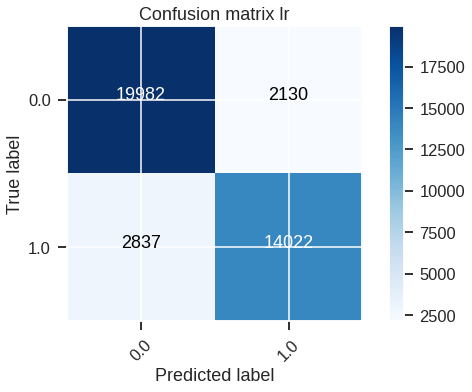

In [70]:
calculate_metrics(output)

In [71]:
metrics_calculation(output.select("label").toPandas(), output.select("prediction").toPandas())

Precision metric: 0.8719007833270507
Recall Metric: 0.8676970715611882
Accuracy Metric: 0.8725462523414846
F1-score Metric: 0.8697938483413369


Training Set AUC: 0.928


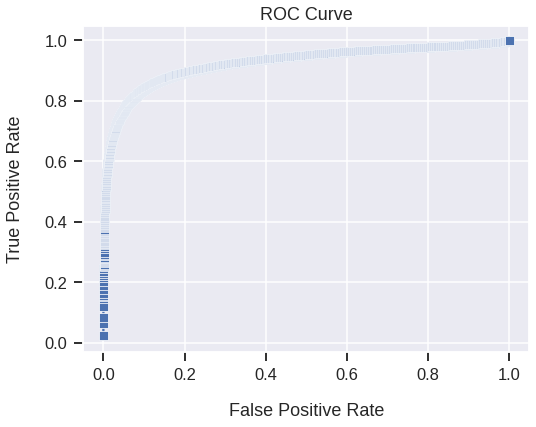

In [72]:
plot_roc(lrmodel)

In [73]:
evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(output)))

Test Set AUC: 0.924


## Decision Tree

In [74]:
from pyspark.ml.classification import DecisionTreeClassifier

lr = DecisionTreeClassifier()

lrmodel = lr.fit(train_df)

output = lrmodel.transform(test_df)

print(output)


DataFrame[Gender: string, Customer Type: string, Age: int, Type of Travel: string, Class: string, Flight Distance: int, Inflight wifi service: int, Departure/Arrival time convenient: int, Ease of Online booking: int, Gate location: int, Food and drink: int, Online boarding: int, Seat comfort: int, Inflight entertainment: int, On-board service: int, Leg room service: int, Baggage handling: int, Checkin service: int, Inflight service: int, Cleanliness: int, Departure Delay in Minutes: int, satisfaction: string, Gender_indexed: double, Customer Type_indexed: double, Class_indexed: double, Type of Travel_indexed: double, Gender_indexed_encoded: vector, Customer Type_indexed_encoded: vector, Class_indexed_encoded: vector, Type of Travel_indexed_encoded: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]


Confusion matrix without normalization
[[20640  1472]
 [ 2131 14728]]


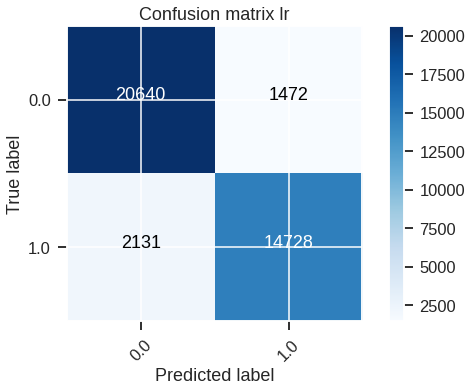

In [75]:
calculate_metrics(output)

In [76]:
metrics_calculation(output.select("label").toPandas(), output.select("prediction").toPandas())

Precision metric: 0.907775928989168
Recall Metric: 0.9035142415998394
Accuracy Metric: 0.9075466372430782
F1-score Metric: 0.9056400717467853


In [83]:
evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(output)))

Test Set AUC: 0.970


## Random Forest

In [78]:
from pyspark.ml.classification import RandomForestClassifier

lr = RandomForestClassifier()

lrmodel = lr.fit(train_df)

output = lrmodel.transform(test_df)

print(output)


DataFrame[Gender: string, Customer Type: string, Age: int, Type of Travel: string, Class: string, Flight Distance: int, Inflight wifi service: int, Departure/Arrival time convenient: int, Ease of Online booking: int, Gate location: int, Food and drink: int, Online boarding: int, Seat comfort: int, Inflight entertainment: int, On-board service: int, Leg room service: int, Baggage handling: int, Checkin service: int, Inflight service: int, Cleanliness: int, Departure Delay in Minutes: int, satisfaction: string, Gender_indexed: double, Customer Type_indexed: double, Class_indexed: double, Type of Travel_indexed: double, Gender_indexed_encoded: vector, Customer Type_indexed_encoded: vector, Class_indexed_encoded: vector, Type of Travel_indexed_encoded: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]


Confusion matrix without normalization
[[20819  1293]
 [ 1805 15054]]


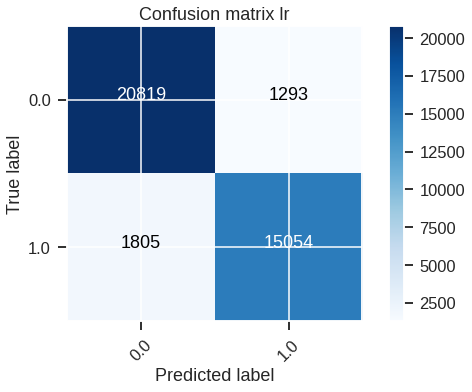

In [79]:
calculate_metrics(output)

In [80]:
metrics_calculation(output.select("label").toPandas(), output.select("prediction").toPandas())

Precision metric: 0.9205601930709941
Recall Metric: 0.9172302439364924
Accuracy Metric: 0.9205049908906623
F1-score Metric: 0.9188922016850095


Training Set AUC: 0.971


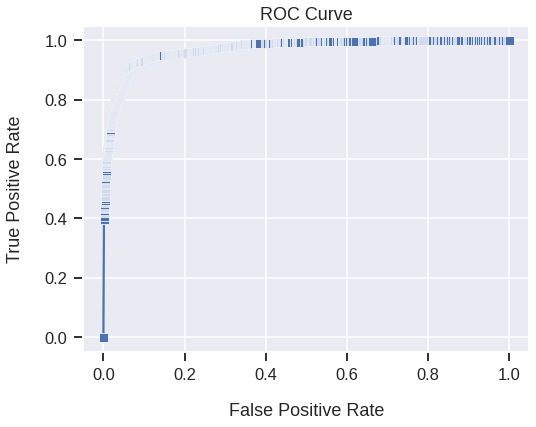

In [81]:
plot_roc(lrmodel)

In [82]:
evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(output)))

Test Set AUC: 0.970


#Hyper-tuning

In [53]:
from pyspark.ml.tuning import CrossValidatorModel

def logistic_regression_pipeline(dataframe: DataFrame,
                                 numerical_features: List[str],
                                 categorical_features: List[str],
                                 target_variable: str,
                                 features_col: str = 'features',
                                 with_std: bool = True,
                                 with_mean: bool = True,
                                 k_fold: int = 5) -> CrossValidatorModel:
  
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline
  
    data_encoder = general_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    classifier = LogisticRegression(featuresCol=features_col, labelCol=LABEL_COL)
    
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    param_grid = ParamGridBuilder()\
        .addGrid(classifier.maxIter, [10, 100, 1000, 10000]) \
        .addGrid(classifier.regParam, [0.0, 0,3, 0.05, 0,7, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0,25, 0.5, 0,75, 1.0]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model